# Now we will try to consider the delta in a notebook alone, because there were many problems

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

import os
import sys
sys.path.append('../dataset/')
sys.path.append('../utility/')

from utility.data_understanding import *
races_df = pd.read_csv(os.path.join('dataset','races.csv'))

In [35]:
# Drop some columns and rename others
columns_to_drop = ['name', 'is_cobbled', 'is_gravel', 'cyclist_team', 'cyclist_age', 'average_temperature']
simple_df = races_df.drop(columns=columns_to_drop)
simple_df.head()

,_url,points,uci_points,length,climb_total,profile,startlist_quality,date,position,cyclist,is_tarmac,delta
0,tour-de-france/1978/stage-6,100.0,NaN,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,0,sean-kelly,True,0.0
1,tour-de-france/1978/stage-6,100.0,NaN,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,1,gerrie-knetemann,True,0.0
2,tour-de-france/1978/stage-6,100.0,NaN,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,2,rene-bittinger,True,0.0
3,tour-de-france/1978/stage-6,100.0,NaN,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,3,joseph-bruyere,True,0.0
4,tour-de-france/1978/stage-6,100.0,NaN,162000.0,1101.0,1.0,1241,1978-07-05 04:02:24,4,sven-ake-nilsson,True,0.0


plot of how delta are distributed w.r.t. the position

and considering different lengths

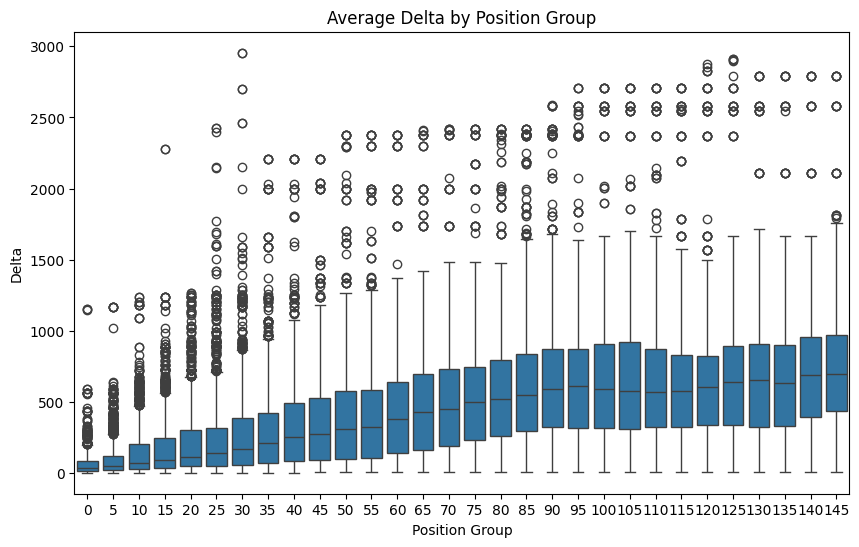

In [36]:
# Filter the data for the first 10 positions and non-zero delta values
filtered_df = simple_df[(simple_df['position'] < 150) & (simple_df['delta'] != 0) & (simple_df['delta'] < 3000) & (simple_df['delta'] > -100)]

# Filter the data for races that are within a given length range
length_range = (250000, 2500000)  # Example length range in meters
filtered_df = filtered_df[(filtered_df['length'] >= length_range[0]) & (filtered_df['length'] <= length_range[1])]

# Create a new column 'position_group' that groups positions in intervals of 5
filtered_df['position_group'] = (filtered_df['position'] // 5) * 5

# Plot the box plot for the average delta by position group
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='position_group', y='delta')
plt.title('Average Delta by Position Group')
plt.xlabel('Position Group')
plt.ylabel('Delta')
plt.show()

We need to remove negative values, too big values, and also, there is a more tricky problem... how many people can arrive at the same time (if we are measuring intervals of 1 second probably a bunch) for shure not 100, we need to understand what is a reeasonable group size in order to avoid considering akwardly big groups in future analysis

Another problem is: how small should be the delta like reasonably can someone arrive 3 hours later than the first person? probably yes in very long races, but probably not in shorter races, this means we should do different analysis based on teh different length

## Understand and clean delta values

Aftem some researches in Setzu office we discovered that it is really common that 150 cyclists arrive together. For this reason the final decision on these is that is reasonable that even 200 cyclist arrive at the same time, given that, as expected this is unusual

In [37]:
# we are cgoing to do things in a for loop, this will probably be a bit slow, but it is not my fault, it is python's fault
groups = []#this will contain (race_id, group_delta, group_size)
for index, row in simple_df.iterrows():
    # first of all we create a list of the "groups" length 
    # (we define a group as a sequence of people that have the same delta)
    if len(groups) == 0:
        groups.append((row['_url'], row['delta'], 1))
    else:
        if groups[-1][1] == row['delta'] and groups[-1][0] == row['_url']:
            groups[-1] = (row['_url'], row['delta'], groups[-1][2] + 1)
        else:
            groups.append((row['_url'], row['delta'], 1))            
print('Groups:', groups[0:4])

Groups: [('tour-de-france/1978/stage-6', 0.0, 5), ('tour-de-france/1978/stage-6', 27.0, 100), ('tour-de-france/1978/stage-6', 64.0, 1), ('vuelta-a-espana/2016/stage-14', 0.0, 1)]


given the plot below the group size seem reasonable as is

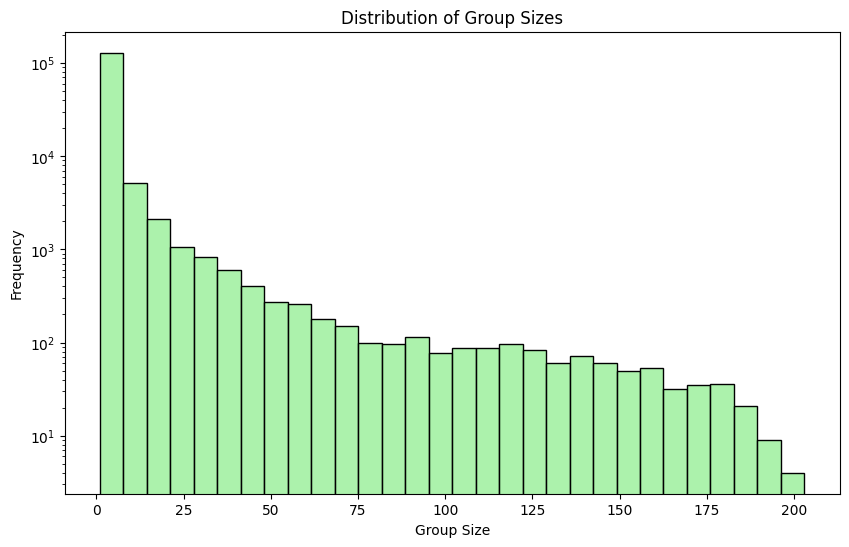

In [38]:
# Extract group sizes
group_sizes = [group[2] for group in groups]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.histplot(group_sizes, bins=30, kde=False, color='lightgreen')
plt.title('Distribution of Group Sizes')
plt.xlabel('Group Size')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

but... the delta itself can have some problems...

let's have a look to the distribution if we don't touch the delta

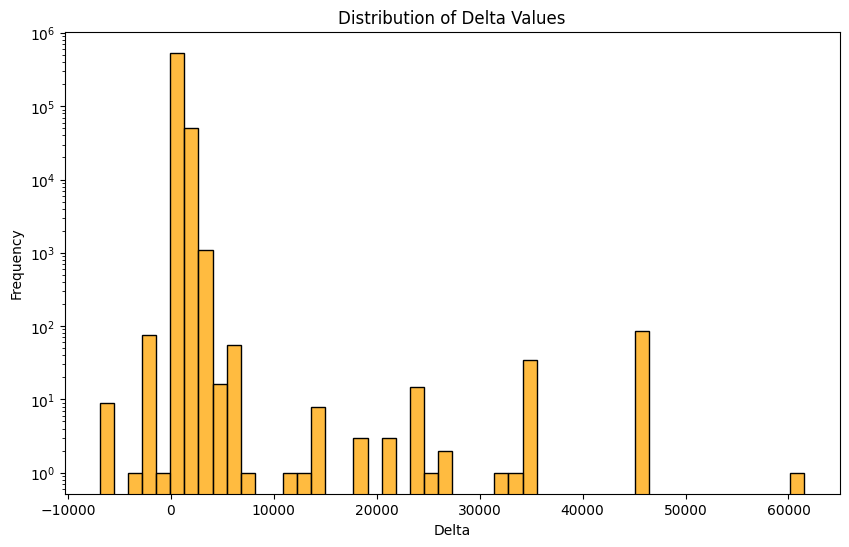

In [39]:
# Plot the distribution of delta values
plt.figure(figsize=(10, 6))
sns.histplot(simple_df['delta'], bins=50, kde=False, color='orange')
plt.title('Distribution of Delta Values')
plt.xlabel('Delta')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

the horror!

and... the so called "trollino"

In [40]:
simple_df[simple_df['_url'].apply(lambda url: url == 'itzulia-basque-country/2001/stage-5b')][-4:]

,_url,points,uci_points,length,climb_total,profile,startlist_quality,date,position,cyclist,is_tarmac,delta
375864,itzulia-basque-country/2001/stage-5b,50.0,NaN,10000.0,NaN,NaN,898,2001-04-14 00:17:58,118,massimo-podenzana,True,185.0
375865,itzulia-basque-country/2001/stage-5b,50.0,NaN,10000.0,NaN,NaN,898,2001-04-14 00:18:05,119,kai-hundertmarck,True,192.0
375866,itzulia-basque-country/2001/stage-5b,50.0,NaN,10000.0,NaN,NaN,898,2001-04-14 00:18:19,120,riccardo-forconi,True,206.0
375867,itzulia-basque-country/2001/stage-5b,50.0,NaN,10000.0,NaN,NaN,898,2001-04-14 17:20:40,121,riccardo-forconi,True,61547.0


looks like, someon (riccardo-forconi) arrived twice, and that the second time he arrived after 17h. Now, I'm no professional cyclist, but I think this is wrong, and there are many duplicate, to solve this problem we will remove time that don't make much sense and, if there are still duplicates we will keep the first instance

we cut at 20000 seconds of delta that is about 5,5h in some very long races it is maybe reasonable to arrive with 5/6 hours of delay, but there are very few instances of these, if someone has higher delta thoug, they are probably wrong records

In [43]:
# Remove rows where delta is greater than 20000
filtered_df = simple_df[simple_df['delta'] <= 20000]
# remove rows where delta is less than -0
filtered_df = filtered_df[filtered_df['delta'] >= 0]
# Remove cyclists that arrived twice in the same race, keeping the first occurrence
filtered_df = filtered_df.drop_duplicates(subset=['_url', 'cyclist'], keep='first')

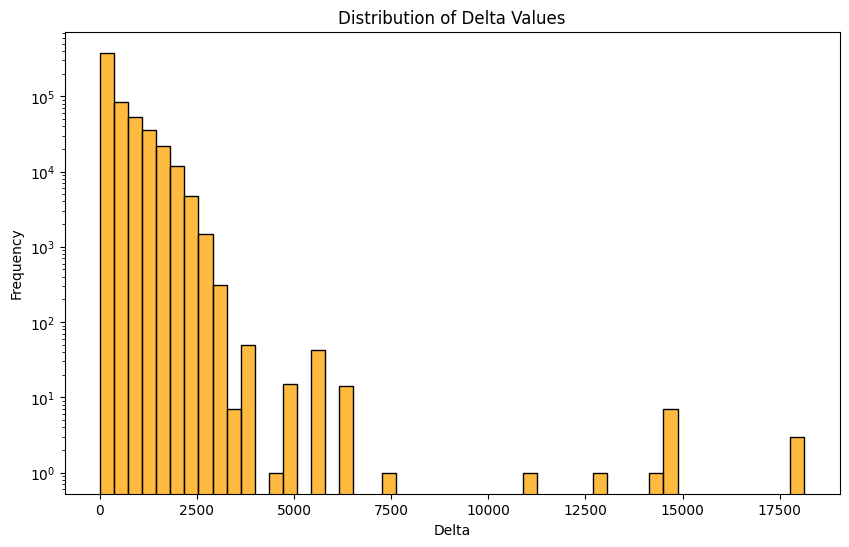

In [44]:
# plot the updated histogram
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['delta'], bins=50, kde=False, color='orange')
plt.title('Distribution of Delta Values')
plt.xlabel('Delta')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

***TODO***: To remove more instances is possible, given that after 5000 they are really rare, but we have no way of checking if these numbers are correct. This will be discussed with the team. (The plot look better if we cut at 3000)

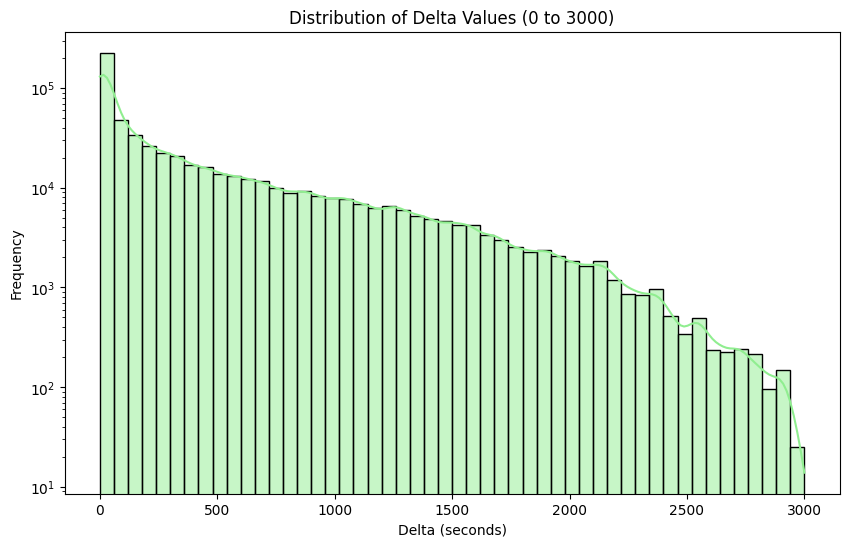

In [45]:
# Filter the data for delta values in the range 0 to 3000
filtered_delta_df = filtered_df[(filtered_df['delta'] <= 3000)]

# Plot the histogram for the filtered delta values
plt.figure(figsize=(10, 6))
sns.histplot(filtered_delta_df['delta'], bins=50, kde=True, color='lightgreen')
plt.title('Distribution of Delta Values (0 to 3000)')
plt.xlabel('Delta (seconds)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

the furder analysis done in the old version of this notebook is to be considered outdated 